/tmp/ipykernel_25058/4167666691.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date Time'] = pd.to_datetime(data['Date Time'], dayfirst=True)
2024-10-20 18:28:59.364094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:86:00.0, compute capability: 7.5
/home/onyxia/work/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-10-20 18:29:03.035115: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900


5256/5256 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - loss: 0.0014 - val_loss: 4.5729e-05
Epoch 2/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 2.2365e-05 - val_loss: 1.3591e-05
Epoch 3/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 1.7370e-05 - val_loss: 2.1558e-05
Epoch 4/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 1.5708e-05 - val_loss: 1.6540e-05
Epoch 5/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 1.5519e-05 - val_loss: 1.5217e-05
Epoch 6/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 1.5170e-05 - val_loss: 1.2822e-05
Epoch 7/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 1.4716e-05 - val_loss: 1.4418e-05
Epoch 8/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - loss: 1.4501e-05 - val_loss: 1.2432e-05
Epoch 9/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 1.4208e-05 - val_loss: 1.2256e-05
Epoch 10/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 1.4146e-05 - val_loss: 1.2995e-05
10512/10512 ━━━━━━━━━━━━━━━━━━━━ 4

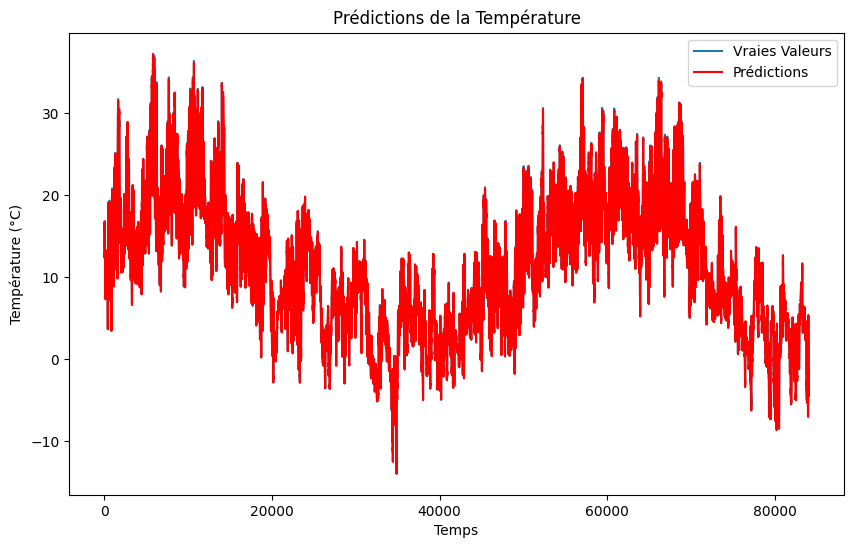

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import zipfile
import os
import requests

# Télécharger et extraire le fichier CSV si nécessaire
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
zip_file_path = 'jena_climate_2009_2016.csv.zip'
csv_file_path = 'jena_climate_2009_2016.csv'

# Télécharger le fichier zip
if not os.path.exists(zip_file_path):
    print("Téléchargement du fichier zip...")
    response = requests.get(url)
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)

# Extraire le fichier CSV si nécessaire
if not os.path.exists(csv_file_path):
    print("Extraction du fichier CSV...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

# Chargement des données
df = pd.read_csv(csv_file_path)

# Gardons uniquement les colonnes les plus pertinentes pour la prédiction
data = df[['Date Time', 'T (degC)', 'p (mbar)', 'rho (g/m**3)']]

# Conversion de la colonne 'Date Time' en datetime
data['Date Time'] = pd.to_datetime(data['Date Time'], dayfirst=True)

# On exclut la colonne 'Date Time' pour la normalisation
data_values = data[['T (degC)', 'p (mbar)', 'rho (g/m**3)']]

# Préparation des données (normalisation)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Fonction pour créer des séquences de données
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]  # Toutes les colonnes sauf la colonne des dates
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # La première colonne (température) comme cible
    return np.array(dataX), np.array(dataY)

# Définir la taille de la fenêtre temporelle
time_step = 60  # Utilisons 60 pas de temps (par exemple 10 heures de données)
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:]

# Créer les ensembles d'entraînement et de test
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape des données en [samples, time steps, features] pour LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverser la normalisation pour obtenir les vraies valeurs
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 2))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 2))), axis=1))[:,0]
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 2))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))), axis=1))[:,0]

# Calculer l'erreur
mse_lstm = mean_squared_error(y_test_actual, test_predict)
print(f"LSTM Mean Squared Error: {mse_lstm}")

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Vraies Valeurs')
plt.plot(test_predict, label='Prédictions', color='red')
plt.title('Prédictions de la Température')
plt.xlabel('Temps')
plt.ylabel('Température (°C)')
plt.legend()
plt.show()
